# Implementação do Random Forest

In [31]:
TRAINING_DATASET_SOURCE = '../datasets/training_data.csv'  # Since we are one directory up, we should go down one directory to import the datasets
TEST_DATASET_SOURCE = '../datasets/test_data.csv'

In [32]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pandas import DataFrame
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# Definição dos dados de teste e de treino

In [33]:
print(train_df.shape, test_df.shape)

(5000, 13) (1206, 12)


In [34]:
train_df['incidents'].value_counts()

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

In [35]:
#count_class0, count_class1, count_class2, count_class3, count_class4 = train_df['incidents'].value_counts().to_frame()

incidents_count = train_df['incidents'].value_counts()

max_count = incidents_count.max()

print('Max value count:', max_count)

df_classes = []
for category, counts in zip(incidents_count.index, incidents_count):
    #print(category, counts)
    df_classes.append(train_df[train_df['incidents'] == category])

df_classes_over = []

for category in df_classes:
    df_classes_over.append(category.sample(max_count, replace=True))

df_test_over = pd.concat(df_classes_over, axis=0)

print(df_test_over['incidents'].value_counts())


Max value count: 2028
None         2028
High         2028
Low          2028
Very_High    2028
Medium       2028
Name: incidents, dtype: int64


In [36]:
features = df_test_over.drop(['incidents'], axis=1)
target = df_test_over['incidents']

all_features = features.columns.tolist()

In [37]:
features

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
3256,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-09-13 16:00,LIGHT,24.0,1011.0,73.0,3.0,0.0,Sem Chuva
4699,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-16 03:00,DARK,15.0,1018.0,81.0,0.0,0.0,Sem Chuva
2502,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-09-18 23:00,DARK,15.0,1021.0,81.0,1.0,0.0,Sem Chuva
3677,Guimaraes,UNDEFINED,0,",",2021-03-11 03:00,DARK,11.0,1025.0,91.0,1.0,0.0,Sem Chuva
677,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-10 06:00,LOW_LIGHT,15.0,1017.0,69.0,1.0,0.0,Sem Chuva
...,...,...,...,...,...,...,...,...,...,...,...,...
3323,Guimaraes,UNDEFINED,815,"N101,N101,N101,N101,N101,N101,N101,N101,N101",2021-07-26 11:00,LIGHT,20.0,1016.0,43.0,1.0,0.0,Sem Chuva
3994,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-03-23 20:00,DARK,11.0,1023.0,82.0,0.0,0.0,Sem Chuva
2046,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-02 12:00,LIGHT,15.0,1018.0,80.0,1.0,0.0,Sem Chuva
3290,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-03-26 06:00,DARK,7.0,1013.0,83.0,2.0,0.0,Sem Chuva


### Obtenção das features numericas e categoricas

In [38]:
dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay', 'record_date']

numerical_features = [column for column, dtype in zip(features.columns, features.dtypes)
                      if dtype.kind in ['i', 'f']]

categorical_features = [column for column, dtype in zip(features.columns, features.dtypes)
                        if
                        dtype.kind not in ['i', 'f'] and column not in ['affected_roads', 'record_date']]

In [39]:
print(numerical_features)
len(all_features)

['delay_in_seconds', 'avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'avg_precipitation']


12

### Divisão dos dados em dados de teste e treino

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=2000)

#### Criação de steps para tratar da remoção de features


In [41]:
# noinspection PyPep8Naming,PyMethodMayBeStatic
class ColumnsRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        X_.drop(columns=dropped_columns, inplace=True)

        return X_

#### Criação de steps para tratar da feature `record_date`

In [42]:
# noinspection PyPep8Naming,PyMethodMayBeStatic
class RecordDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        ### Extrair a hora e dia da semana da feature 'record_date'
        record_date = pd.DatetimeIndex(X_['record_date'])

        X_['hour'] = record_date.hour
        X_['day'] = record_date.day
        X_['month'] = record_date.month
        X_['weekday'] = record_date.weekday

        X_.drop(columns=['record_date'], inplace=True)

        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler()

        imputer.fit(X_)
        X_ = imputer.transform(X_)

        scaler.fit(X_)
        X_ = scaler.transform(X_)

        return X_

#### Criação de steps para tratar da feature `affected_roads`

In [43]:
# noinspection PyPep8Naming,PyMethodMayBeStatic
class AffectedRoadsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        road_quantity = []
        for line in X_['affected_roads']:
            unique_roads = set(str(line).split(','))
            valid_roads = [elem for elem in unique_roads if elem != '']
            count = len(valid_roads)
            road_quantity.append(count)

        X_['num_affected_roads'] = road_quantity
        X_.drop(columns=['affected_roads'], inplace=True)

        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler()

        imputer.fit(X_)
        X_ = imputer.transform(X_)

        scaler.fit(X_)
        X_ = scaler.transform(X_)

        return X_

### Pipeline de preparação de dados

In [44]:
from sklearn.preprocessing import KBinsDiscretizer

preprocessor = make_column_transformer(
    (make_pipeline(
        AffectedRoadsTransformer()
    ), ['affected_roads']),

    (make_pipeline(
        RecordDateTransformer()
    ), ['record_date']),

    #(make_pipeline(
    #    ColumnsRemovalTransformer()
    #), dropped_columns),

    (make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(),
        KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', random_state=1000),
    ), numerical_features),

    (make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(categories='auto', handle_unknown='ignore'),
    ), categorical_features),
)

In [45]:
X_train

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
309,Guimaraes,UNDEFINED,2268,"N101,N101,N101,N101,N101",2021-10-31 00:00,DARK,15.0,1008.0,91.0,1.0,0.0,chuva fraca
4981,Guimaraes,UNDEFINED,171,"N101,N101,N101,N101,N101",2021-10-23 10:00,LIGHT,16.0,1022.0,61.0,1.0,0.0,Sem Chuva
1605,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-15 01:00,DARK,14.0,1012.0,75.0,2.0,0.0,Sem Chuva
3748,Guimaraes,UNDEFINED,122,NaN,2021-03-08 20:00,DARK,11.0,1013.0,57.0,3.0,0.0,Sem Chuva
2746,Guimaraes,MAJOR,2360,"N101,N101,N105,N101,N105,N105,",2021-12-24 13:00,LIGHT,12.0,1006.0,90.0,2.0,0.0,Sem Chuva
...,...,...,...,...,...,...,...,...,...,...,...,...
4557,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-20 11:00,LIGHT,16.0,1010.0,83.0,0.0,0.0,Sem Chuva
2621,Guimaraes,UNDEFINED,340,"N101,N101,N101,N101,N101,N101",2021-10-30 13:00,LIGHT,17.0,1008.0,88.0,2.0,0.0,Sem Chuva
2367,Guimaraes,UNDEFINED,0,"N101,N101",2021-12-09 02:00,DARK,8.0,1024.0,93.0,1.0,0.0,Sem Chuva
3228,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-07 23:00,DARK,15.0,1022.0,81.0,0.0,0.0,chuva fraca


In [46]:
preprocessor.fit(X_train)
preprocessor.transform(X_train)

C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:257: UserWarning: Feature 5 is constant and will be replaced with 0.
  warnings.warn(


array([[0.125     , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.125     , 0.43478261, 0.73333333, ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 0.04347826, 0.46666667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.125     , 0.08695652, 0.26666667, ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 1.        , 0.2       , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.17391304, 0.6       , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif

preprocessor_best = make_pipeline(preprocessor)  #, VarianceThreshold(), SelectKBest(f_classif, k='all'))

In [48]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = make_pipeline(preprocessor_best,
                         RandomForestClassifier(n_estimators=50, max_leaf_nodes=18, min_samples_leaf=5,
                                                max_features='sqrt', max_depth=20, n_jobs=-1, bootstrap=True, random_state=1000))

In [49]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:257: UserWarning: Feature 5 is constant and will be replaced with 0.
  warnings.warn(


0.702451394759087

In [50]:
RF_Model.score(X_test, y_test)

0.703155818540434

## Hyperparameter Tuning

In [51]:
import numpy as np

n_estimators = [int(x) for x in np.linspace(start=10, stop=50, num=2)]

max_features = [int(x) for x in np.linspace(start=2, stop=12, num=3)]

max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=5)]

min_samples_split = [int(x) for x in np.linspace(start=2, stop=30, num=2)]  #[2, 5, 10, 20]

min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=30, num=2)]  # [1, 2, 5, 10]

max_leaf_nodes = [int(x) for x in np.linspace(start=20, stop=80, num=2)]

bootstrap = [True, False]

criterions = ["gini", "entropy", "log_loss"]

In [52]:
param_grid = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__max_leaf_nodes': max_leaf_nodes,
    'randomforestclassifier__bootstrap': bootstrap,
    'randomforestclassifier__criterion': criterions
}

param_grid

{'randomforestclassifier__n_estimators': [10, 50],
 'randomforestclassifier__max_features': [2, 7, 12],
 'randomforestclassifier__max_depth': [10, 32, 55, 77, 100],
 'randomforestclassifier__min_samples_split': [2, 30],
 'randomforestclassifier__min_samples_leaf': [2, 30],
 'randomforestclassifier__max_leaf_nodes': [20, 80],
 'randomforestclassifier__bootstrap': [True, False],
 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [53]:
from sklearn.model_selection import GridSearchCV

rf_RandomGrid = RandomizedSearchCV(estimator=RF_Model, param_distributions=param_grid, cv=10, verbose=1, n_jobs=-2,
                                   n_iter=50, random_state=1000, scoring='balanced_accuracy')


#rf_RandomGrid = GridSearchCV(estimator=RF_Model, param_grid=param_grid, cv=10, verbose=1, n_jobs=-1, scoring='balanced_accuracy')

In [54]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:257: UserWarning: Feature 5 is constant and will be replaced with 0.
  warnings.warn(


CPU times: total: 4.05 s
Wall time: 12.1 s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('affectedroadstransformer',
                                                                                                                 AffectedRoadsTransformer())]),
                                                                                                ['affected_roads']),
                                                                                               ('pipeline-2',
                                                                                                Pipeline(steps=[('recorddatetransformer',
                                                                                                                 RecordDateTransformer())]),
                                                                                                ['record_date']),
                                                                                               ('pipeline-...
                                        'randomforestclassifier__max_depth': [10,
                                                                              32,
                                                                              55,
                                                                              77,
                                                                              100],
                                        'randomforestclassifier__max_features': [2,
                                                                                 7,
                                                                                 12],
                                        'randomforestclassifier__max_leaf_nodes': [20,
                                                                                   80],
                                        'randomforestclassifier__min_samples_leaf': [2,
                                                                                     30],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      30],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 50]},
                   random_state=1000, scoring='balanced_accuracy', verbose=1)

In [55]:
rf_RandomGrid.score(X_train, y_train)

0.8222089418116703

In [56]:
rf_RandomGrid.best_score_

0.805576428411275

In [57]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('affectedroadstransformer',
                                                                                    AffectedRoadsTransformer())]),
                                                                   ['affected_roads']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('recorddatetransformer',
                                                                                    RecordDateTransformer())]),
                                                                   ['record_date']),
                                                                  ('pipeline-3',
                                                                   Pipeline(steps=[('simpleimputer'...
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['city_name',
                                                                    'magnitude_of_delay',
                                                                    'luminosity',
                                                                    'avg_rain'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=77,
                                        max_features=12, max_leaf_nodes=80,
                                        min_samples_leaf=2, n_estimators=10,
                                        n_jobs=-1, random_state=1000))])

In [58]:
print(f'Train: {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test: {rf_RandomGrid.score(X_test, y_test):.3f}')

Train: 0.822
Test: 0.809


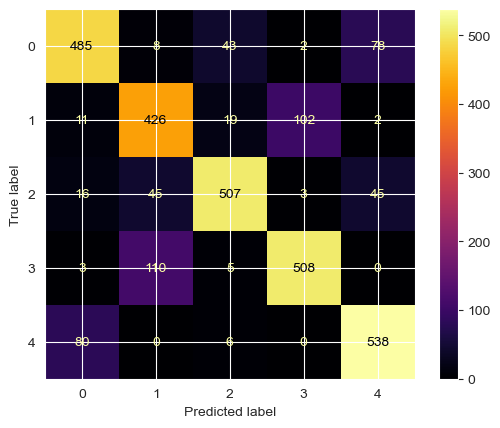

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_RandomGrid.predict(X_test)

cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap='inferno')

### Obtenção das previsões do dataset de submissão

In [60]:
features = test_df.copy()

preprocessor.fit(features)
preprocessor.transform(features)

predictions = rf_RandomGrid.predict(features)
predictions_df = pd.DataFrame(predictions)
predictions_df.index += 1
predictions_df.to_csv("../submission.csv", header=['Incidents'], index_label='RowId')

C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\preprocessing\_discretization.py:257: UserWarning: Feature 5 is constant and will be replaced with 0.
  warnings.warn(
